In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [13]:
datasets = ['mt_bench', 'trivia_qa', 'alpaca']
combined_data_list = []

In [14]:
for dataset in datasets:
    # Define file paths for each dataset
    vanilla_data_path = f'/home/yixiaozeng/DynaSD/results/{dataset}/vanilla_inference_{dataset}_probabilistic.csv'
    sd_data_path = f'/home/yixiaozeng/DynaSD/results/{dataset}/sd_inference_{dataset}_probabilistic_temp_0.7_gamma_4.csv'
    mcsd_data_path = f'/home/yixiaozeng/DynaSD/results/{dataset}/mcsd_inference_{dataset}_probabilistic_4221.csv'
    dynasd_data_path = f'/home/yixiaozeng/DynaSD/results/with_temperature0.7_old_32precision/4&4/dynasd_inference_{dataset}_probabilistic.csv'

    # Load data for vanilla, SD, MCSD, and DynaSD methods
    vanilla_data = pd.read_csv(vanilla_data_path, header=None, names=['target_model', 'speed'])
    sd_data = pd.read_csv(sd_data_path, header=None, names=['draft_model', 'target_model', 'speed', 'acc_rate'])
    mcsd_data = pd.read_csv(mcsd_data_path, header=None, names=['draft_model', 'target_model', 'speed', 'acc_rate'])
    dynasd_data = pd.read_csv(dynasd_data_path, header=None, names=['draft_model', 'target_model', 'speed', 'acc_rate'])

    # Calculate speedups for each method relative to vanilla speed
    sd_data = sd_data.merge(vanilla_data, on='target_model', suffixes=('', '_vanilla'))
    mcsd_data = mcsd_data.merge(vanilla_data, on='target_model', suffixes=('', '_vanilla'))
    dynasd_data = dynasd_data.merge(vanilla_data, on='target_model', suffixes=('', '_vanilla'))

    sd_data['speedup'] = sd_data['speed'] / sd_data['speed_vanilla']
    mcsd_data['speedup'] = mcsd_data['speed'] / mcsd_data['speed_vanilla']
    dynasd_data['speedup'] = dynasd_data['speed'] / dynasd_data['speed_vanilla']

    # Simplify model names
    model_short_names = {
        'TinyLlama/TinyLlama-1.1B-Chat-v1.0': 'TinyLlama 1.1B',
        'lmsys/vicuna-7b-v1.5': 'Vicuna 7B',
        'meta-llama/Llama-2-7b-chat-hf': 'Llama 2 7B Chat',
        'JackFram/llama-68m': 'Llama 68M',
    }

    sd_data.replace({'draft_model': model_short_names, 'target_model': model_short_names}, inplace=True)
    mcsd_data.replace({'draft_model': model_short_names, 'target_model': model_short_names}, inplace=True)
    dynasd_data.replace({'draft_model': model_short_names, 'target_model': model_short_names}, inplace=True)

    # Add dataset to identify rows later for averaging
    sd_data['dataset'] = dataset
    mcsd_data['dataset'] = dataset
    dynasd_data['dataset'] = dataset

    # Concatenate into a unified DataFrame for each dataset
    combined_data = pd.concat([
        sd_data[['draft_model', 'target_model', 'speedup', 'dataset']].assign(method='SD'),
        mcsd_data[['draft_model', 'target_model', 'speedup', 'dataset']].assign(method='MCSD'),
        dynasd_data[['draft_model', 'target_model', 'speedup', 'dataset']].assign(method='DynaSD')
    ])
    combined_data_list.append(combined_data)

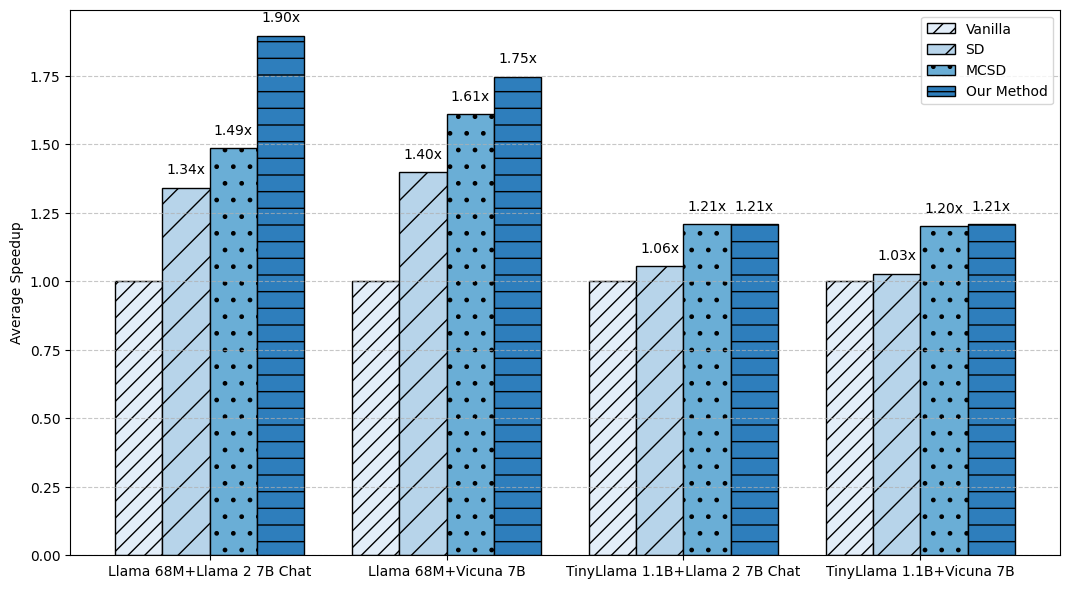

In [15]:
# Concatenate all dataset data and compute average speedup per model pair
combined_data_all = pd.concat(combined_data_list)
average_speedup_data = combined_data_all.groupby(['draft_model', 'target_model', 'method']).agg({'speedup': 'mean'}).reset_index()

# Prepare data for plotting
average_speedup_data['label'] = average_speedup_data['draft_model'] + '+' + average_speedup_data['target_model']
average_speedup_data.sort_values(by=['label', 'speedup'], ascending=[True, False], inplace=True)

labels = average_speedup_data['label'].unique()
x = range(len(labels))

# Define colors for each method
color_scale = plt.cm.Blues
color_dynasd = color_scale(0.7)
color_mcsd = color_scale(0.5)
color_sd = color_scale(0.3)
color_vanilla = color_scale(0.1)

plt.figure(figsize=(12, 6))
width = 0.2

# Plotting bars with hatch patterns for each method
plt.bar(x, [1] * len(x), width=width, label='Vanilla', color=color_vanilla, align='center', edgecolor='black', hatch='//')
plt.bar([p + width for p in x], average_speedup_data[average_speedup_data['method'] == 'SD']['speedup'], 
        width=width, label='SD', color=color_sd, align='center', edgecolor='black', hatch='/')
plt.bar([p + 2 * width for p in x], average_speedup_data[average_speedup_data['method'] == 'MCSD']['speedup'], 
        width=width, label='MCSD', color=color_mcsd, align='center', edgecolor='black', hatch='.')
plt.bar([p + 3 * width for p in x], average_speedup_data[average_speedup_data['method'] == 'DynaSD']['speedup'], 
        width=width, label='Our Method', color=color_dynasd, align='center', edgecolor='black', hatch='-')

# Label and annotate plot
plt.ylabel('Average Speedup')
plt.xticks([p + 1.5 * width for p in x], labels, rotation=0, ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='best', bbox_to_anchor=(1, 1))

# Annotate each bar with the average speedup value
for i, v in enumerate(average_speedup_data[average_speedup_data['method'] == 'DynaSD']['speedup']):
    plt.text(i + 3 * width, v + 0.05, f"{v:.2f}x", color='black', ha='center', fontsize=10)
for i, v in enumerate(average_speedup_data[average_speedup_data['method'] == 'MCSD']['speedup']):
    plt.text(i + 2 * width, v + 0.05, f"{v:.2f}x", color='black', ha='center', fontsize=10)
for i, v in enumerate(average_speedup_data[average_speedup_data['method'] == 'SD']['speedup']):
    plt.text(i + width, v + 0.05, f"{v:.2f}x", color='black', ha='center', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.9, 1])

plt.savefig('speedup_comparison.pdf')